<table>
    <tr><td><b>Names</b></td><td>Kivits & Stoffels</td></tr>
    <tr><td><b>Group</b></td><td>38</td></tr>
</table>

$
\newcommand{\x}{\mathbf{x}}
\newcommand{\w}{\mathbf{w}}
\newcommand{\z}{\mathbf{z}}
\newcommand{\wx}{\w^\top\x}
\newcommand{\dataset}{\mathbf{X}}
\newcommand{\tset}{t\negthickspace t}
$

# Week 4: Neural networks

The basic unit of a multi-layer perceptron (MLP) is the neuron, which is a computational unit that computes a weighted sum of its inputs $\wx$ and pushes this through a non-linear activation function. Important is that this activation should be differentiable, as we will train the weights of the network by gradient descent. This requires that we should be able to compute the gradient of an error function with respect to the weights. 

In a sense, this whole lab is about taking derivatives and applying the chain rule of derivation. As a reminder, the rule is that the derivative of a function $f$ applied to the result of a function $g$ $f(g(x))$ can be decomposed as:
$$
\frac{\partial}{\partial x} f(g(x)) = \frac{\partial f(g(x))}{\partial g(x)} \, \frac{\partial g(x)}{\partial x} 
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import copy


def gradDesc(w, errorfn, gradfn,  eta=1e-3, verbose=True, maxit=100):
    """Find a minimum of a function using Gradient Descent
    
    Inputs:
        w: Initialisation of the weights
        errorfn: the function of w to minimise
        gradfn:  The gradient of that function w.r.t. w
        eta:     The initial value of the step size
        verbose: Whether to print out progress information
        
    Outputs:
        - The value of w at which the minimum is achieved
        - a list errors for the different iterations
        - a list of the corresponding time steps
    
    """
    err = errorfn(w)             # Compute the error function
    errs = np.zeros(maxit)       # Keep track of the error function
    ts = np.zeros(maxit)         # Keep track of time stamps
    start = time.time()

    newError = errorfn(w) + 1.
    for n in range(maxit):
        grad = gradfn(w)
        if verbose:
            print("##", n, "err:", newError, "eta:", eta, "w:", w)
            print("  Gradient:", grad)
           # print("  FD grad: ", gradfd(w,errorfn,delta))
        pw = copy.copy(w)
        w -= grad * eta     # Update the weights
        
        pastError = newError
        newError = errorfn(w)
        while eta > 0. and pastError - newError < 0: # If the error increases, eta is too large
            eta /= 2.0                                # halve it, and
            w = pw - eta * grad                      # try again from the original value of the weights
            newError = errorfn(w)
        else:                                        # If the error goes down,
            eta *= 1.2                               # try to increase eta a little, to speed up things.
                
        if pastError-newError < 1e-5:                # If we couldn't decrease the error anymore, 
            return w, errs[:n], ts[:n]               # just give up
 
        errs[n] = newError                           # Keep track of how the errors evolved
        ts[n] = time.time()-start

    return w, errs, ts


def sigma(a):
    """Numerically stable implementation of the logistic function"""
    return 0. if a<-40. else 1. if a>40. else 1./(1.+np.exp(-a))
sigma = np.vectorize(sigma) # make sigma work elementwise on vectors too

def gradSigma(a):
    """Return the derivative of the logistic function w.r.t. its function parameter"""
    s = sigma(a)
    return s*(1.-s)


## Neuron definition

In this case, let's set up our network to have the sigmoidal activation function that we've seen before in logistic regression, 
$$
\sigma(a) = \frac{1}{1+e^{-a}}\ ,
$$ 
so that the activation $z_i$ of neuron $i$ in the first computational layer is given by
$$
z_i = \sigma(\w_i^\top \x) \ ,
$$
where $\x$ is the input datapoint, and $\w_i$ is the set of input weights to neuron $i$. Other activation functions are possible, such as a linear function ($z=\wx$) or a hyperbolic tangent ($z=\tanh(\wx)$). Let's consider a network of a single neuron, then the output of our network $y(\w,\x) = \sigma(\wx)$.

## Training

To train a single neuron, we have a set of datapoints $\dataset = \{ \x_1\dots \x_N\}$ and corresponding targets $\tset = \{ t_1 \dots t_N \}$. We use this dataset to find optimal weights, and we define optimality on terms of an error function. Let's define our error function as a sum of squared errors:
$$
E(\w) = \tfrac{1}{2} \sum_{n=1}^N (y(\w,\x_n) - t_n)^2
$$

Notice how, although our single neuron is very similar to the logistic regression we saw in previous weeks, our error function is now quite different. The error for our set $\dataset, \tset$ is now:
$$
E(\w) = \frac{1}{2}\sum_{n=1}^N (\sigma(\w^\top\x_n) - t_n)^2
$$

**Question 1 [5 credits]** What is the partial derivative of this error with respect to the $i$th weight of the neuron, $w_i$? Be careful, this is not the same as what we saw in the lecture, where the output neuron had a linear activation function. Remember that $\w^\top\x \triangleq \sum_{i=0}^D w_i x_i$

ANSQ1
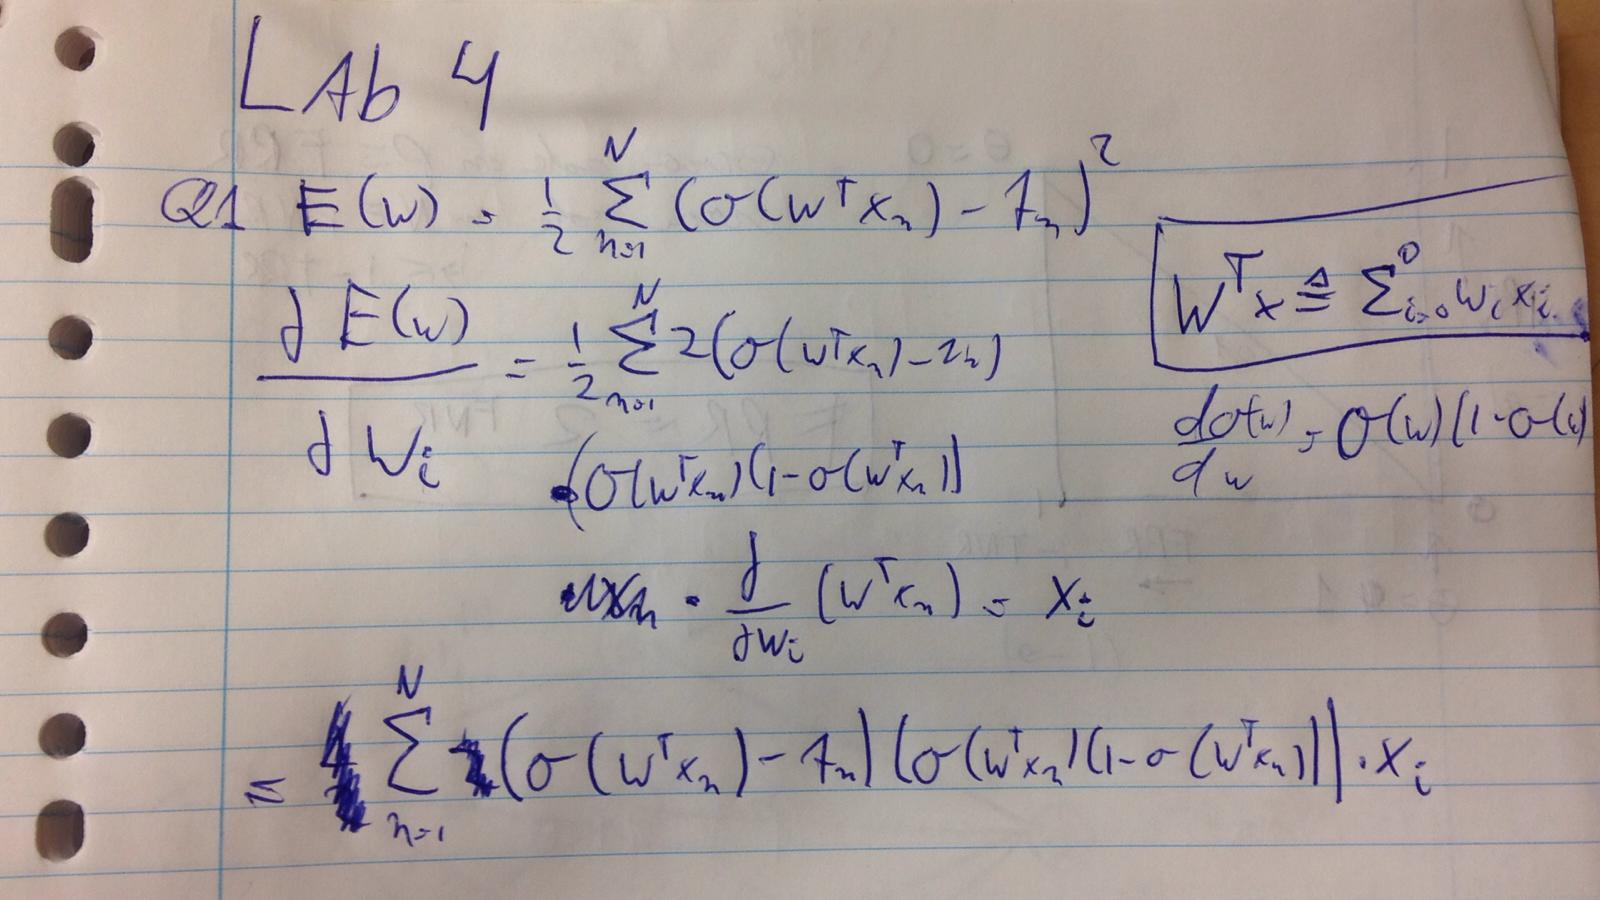
/ANSQ1

**Question 2 [10 credits]** If now we had a neural network with two layers of one neuron each (one hidden and one output node), both with sigmoidal activation functions, 
* what would be the error function, analytically? 
* What is the derivative of that error with respect to the weights of the first and second layer?

For ease of notation, let's assume there is no bias term in the second layer. The input is still a vector $
\x$ with multiple dimensions, however.

How do your equations correspond to the quantities computed in backpropagation?

ANSQ2

One hidden layer with a bias and weights for the vector 'x'. 
One output node without a bias. 
Sigma activiaton function of the both leads to two nested sigma's. 

$$
E(\w) = \frac{1}{2}\sum_{n=1}^N (\sigma(\w_{n}^{2,\top}(\sigma(\w_{n}^{1,\top}\x_n))) - t_n)^2
$$
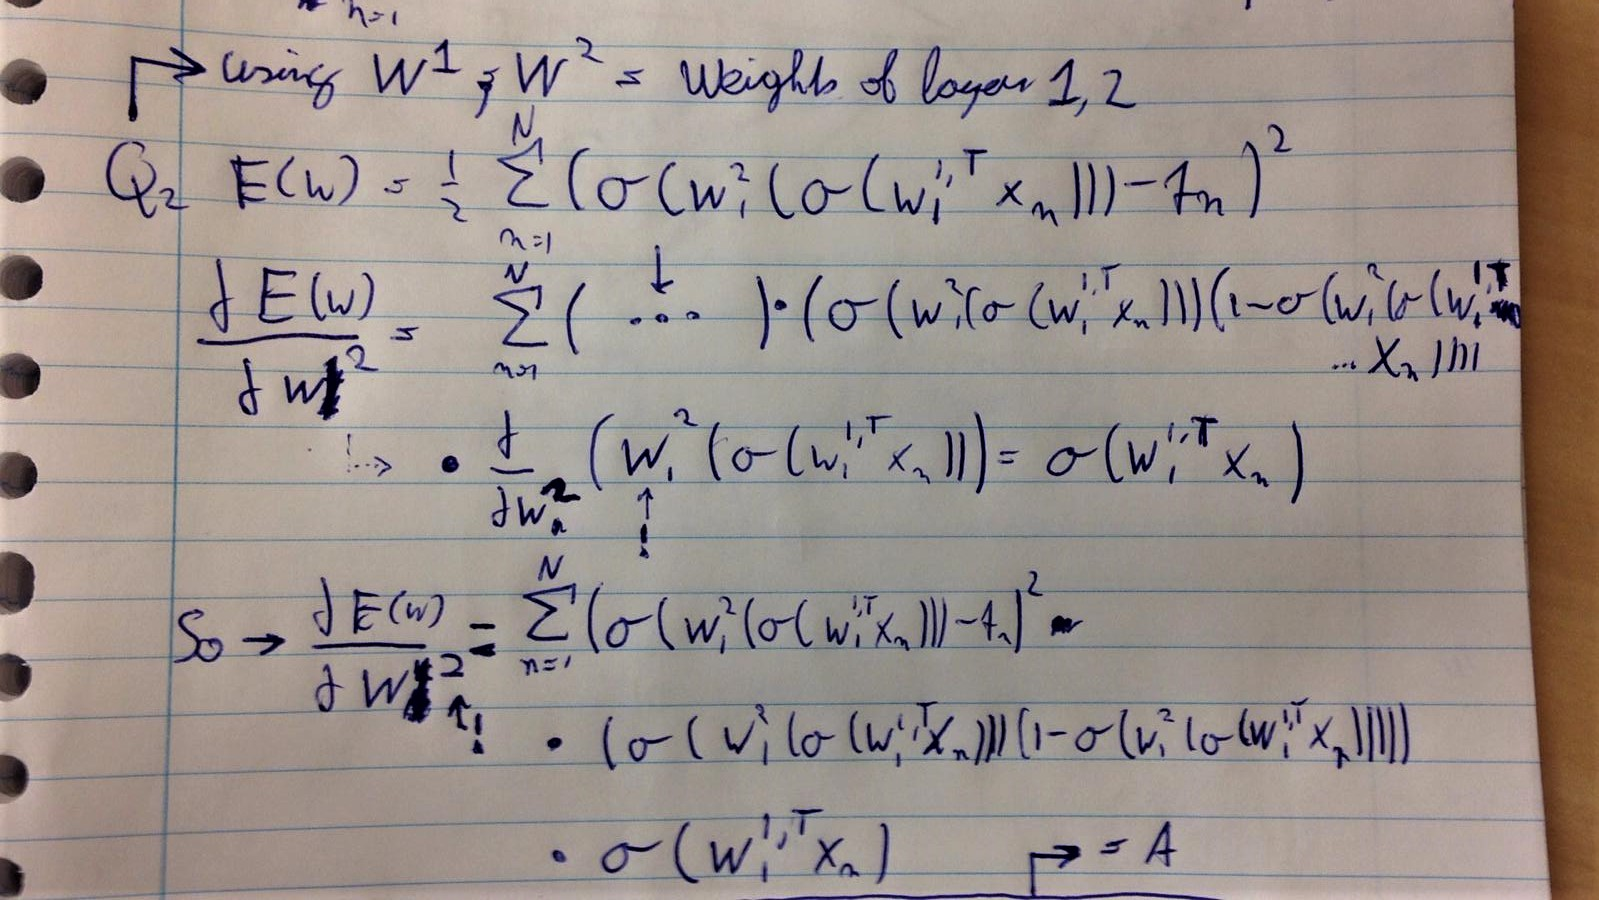
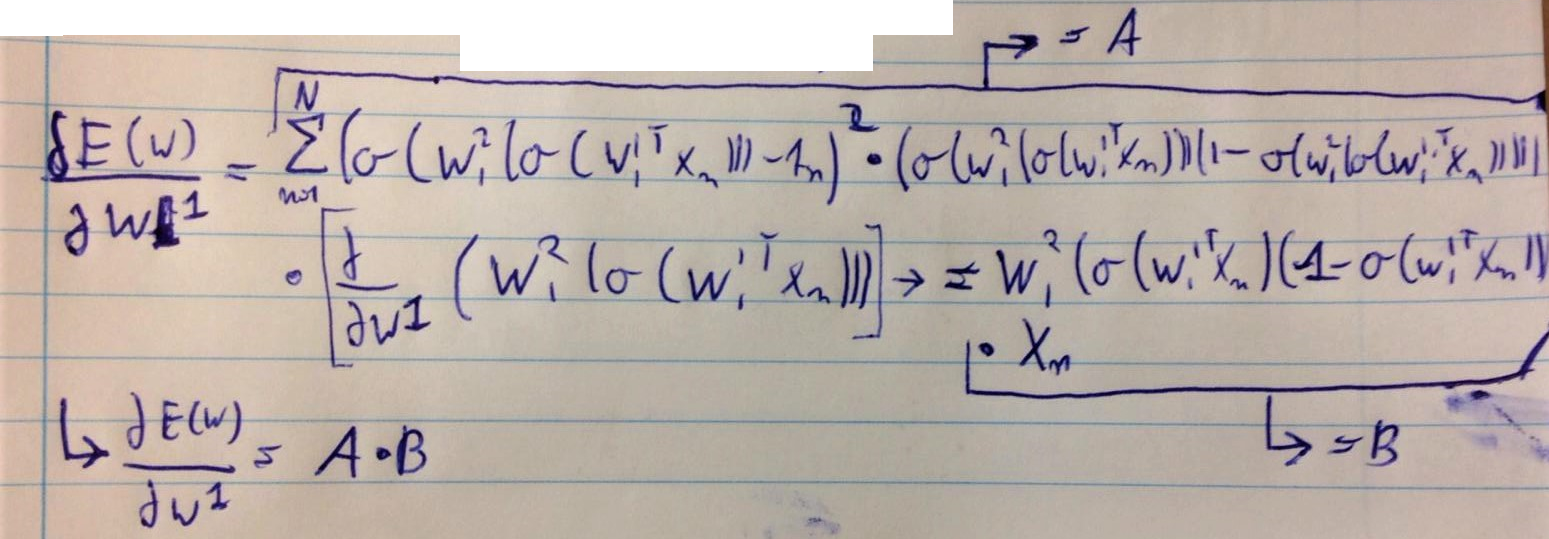
/ANSQ2


**Question 3 [10 credits]** Implement the following python functions: 

* `sse(output, target)`, which implements the squared error between the given network output and the corresponding target. Both are assumed to be scalars, not vectors. 
* `gradSse(output,target)`, which computes the gradient of that error with respect to its input variable `output`
* `neuron(weights, inputs)`, wich implements a neuron with sigmoidal activation function, weights $\w$ and inputs $\x$. Assume that this function will receive an augmented vector $\x$, where the first element is fixed to $1$, so you do not need to handle the bias parameter separately
* `gradNeuron(weights, inputs)`, which implements the gradient of the neuron's output with respect to the neuron's weights.

In [2]:
#ANSQ3
def sse(output, target):
    return (output-target)**2
   
def gradSse(output,target):
    return -2*(output-target)

def neuron(weights,inputs):
    y = np.dot(weights,inputs)
    return sigma(y)
 
def gradNeuron(weights,inputs):
    a = np.dot(weights,inputs)
    GradZ = gradSigma(a)
    return [i*GradZ for i in inputs]
#/ANSQ3

**Question 4 [10 credits]** Verify using finite differences that the gradients you implemented for the above functions is actually correct. To do this, we do a few runs with randomly sampled weights and inputs. In each run, compare the analytically computed gradient (the output of ``gradNeuron`` implemented above) with the result from finite differences (computed with ``neuron`` implemented above, and applying finite differences to the weights). Remember how the gradient is the vector of derivatives of the function with respect to each of the dimensions of the variable (in this case, the vector of weights). This derivative is given by

$$
    \frac{\partial f(\w)}{\partial w_i} = \lim_{\delta \rightarrow 0} \frac{f(w_0, \dots, w_i+\delta, \dots) - f(w_0, \dots, w_i-\delta, \dots)}{2 \delta}
$$

which, in case of finite differences, is approximated by some small (non-zero) value of $\delta$

In [3]:
#ANSQ4
import random as rd

delta = 1e-5

#Finit difference method to calc derivative
def gradfd(weights,inputs,delta):
   
    for iFD in range(len(weights)):
        Fweights = weights[iFD]+delta
        Bweights = weights[iFD]-delta
       
    forwardGrad = neuron(Fweights,inputs)
    backwardGrad = neuron(Bweights,inputs)    
    Grad = (forwardGrad-backwardGrad)/(2*delta)
    return Grad

def verifyGradient(n,verbose):
   
    Diff=FDGrad=TestGrad=[]
   
    for i in range(n):
        #random weights inputs generation
        weights = [rd.uniform(0, 1) for _ in range(0, 5)]
        inputs = [rd.uniform(0, 1) for _ in range(0, 5)]
     
        FDGradi = gradfd(weights,inputs,delta)
        TestGradi = gradNeuron(weights,inputs)
        Diffi = FDGradi - TestGradi
       
        FDGrad.append(FDGradi)
        TestGrad.append(TestGradi)
        Diff.append(Diffi)
       
        if verbose == 1:
            print('FD:       ',FDGradi)
            print('Analytical',np.round(TestGradi,8))
            print('DIFF      ',Diffi,'\n')
       
    meanDiff = np.mean(Diff)
    varDiff = np.var(Diff)
    if verbose == 1:
        print('MeanDiff',meanDiff)
        print('Variance',varDiff)
    return meanDiff, varDiff

verifyGradient(100,1)
#/ANSQ4

FD:        [0.08380041 0.1943209  0.16718642 0.05183412 0.12874484]
Analytical [0.04473947 0.12324236 0.09892561 0.02720684 0.07167117]
DIFF       [0.03906094 0.07107855 0.06826082 0.02462728 0.05707367] 

FD:        [0.00464737 0.20215567 0.06423452 0.14619295 0.23792086]
Analytical [0.00402781 0.17665776 0.05571679 0.12724737 0.20858844]
DIFF       [0.00061955 0.02549791 0.00851773 0.01894558 0.02933242] 

FD:        [0.22654399 0.11985106 0.15674535 0.14089173 0.11949964]
Analytical [0.15625155 0.0800258  0.10556095 0.09450592 0.07978561]
DIFF       [0.07029244 0.03982526 0.0511844  0.0463858  0.03971403] 

FD:        [0.01127915 0.03895    0.13457249 0.05663264 0.12392938]
Analytical [0.00804112 0.02790559 0.1031268  0.04082353 0.09379724]
DIFF       [0.00323802 0.01104441 0.03144569 0.01580911 0.03013215] 

FD:        [0.22075227 0.04897205 0.21117332 0.01712451 0.17396309]
Analytical [0.10270752 0.02274859 0.09823681 0.00795414 0.08088693]
DIFF       [0.11804475 0.02622345 0.1129

(0.07785246409604724, 0.0037853706591341)

### Training a single neuron

We now have the code to implement gradient descent on a single neuron. We simply need to apply the chain rule of derivation to get the complete gradient.

**Question 5 [10 marks]** 
Implement the error function and the gradient of the error function with respect to the weights. Then use the ```gradDesc``` function (provided in the top code box) to perform gradient descent and optimise the weights based on the provided data. Plot the evolution of the error in one plot, and the function that the neuron implements overlayed with the training data (in another plot)


In [4]:
data = np.load("curve.npz")
train = np.array([data['train'][:,0]]).T
traint = data['train'][:,1]

Error is: 2.3788854137065
Gradient error is: [0.78425125 0.71495191]
## 0 err: 3.3788854137065 eta: 0.001 w: [0, 0]
  Gradient: [0.78425125 0.71495191]
## 1 err: 2.377759631264317 eta: 0.0012 w: [-0.00078425 -0.00071495]
  Gradient: [0.78353727 0.71454927]
## 2 err: 2.3764108278394445 eta: 0.0014399999999999999 w: [-0.0017245  -0.00157241]
  Gradient: [0.78268015 0.7140656 ]
## 3 err: 2.3747953380677673 eta: 0.0017279999999999997 w: [-0.00285156 -0.00260067]
  Gradient: [0.7816511  0.71348447]
## 4 err: 2.3728611759655567 eta: 0.0020735999999999997 w: [-0.00420225 -0.00383357]
  Gradient: [0.78041553 0.71278609]
## 5 err: 2.370546551762683 eta: 0.0024883199999999996 w: [-0.00582052 -0.0053116 ]
  Gradient: [0.77893187 0.71194657]
## 6 err: 2.367778171278491 eta: 0.0029859839999999993 w: [-0.00775875 -0.00708315]
  Gradient: [0.77715009 0.71093708]
## 7 err: 2.3644693087941837 eta: 0.003583180799999999 w: [-0.01007931 -0.009206  ]
  Gradient: [0.77501005 0.70972277]
## 8 err: 2.36051765

## 85 err: 0.9880266895740183 eta: 10.498710325370066 w: [  4.34572539 -11.63852782]
  Gradient: [-0.02753444  0.00336202]
## 86 err: 0.9872056228871803 eta: 12.598452390444079 w: [  4.63480152 -11.67382469]
  Gradient: [0.02603677 0.02708985]
## 87 err: 0.9840659759961823 eta: 7.559071434266447 w: [  4.47079002 -11.84446981]
  Gradient: [-0.02076657  0.00577496]
## 88 err: 0.98236250761911 eta: 9.070885721119737 w: [  4.62776598 -11.88812314]
  Gradient: [0.00554283 0.01722738]
## 89 err: 0.980782841406785 eta: 10.885062865343684 w: [  4.57748765 -12.04439072]
  Gradient: [-0.01702895  0.0069003 ]
## 90 err: 0.9792957050252994 eta: 13.062075438412421 w: [  4.76284886 -12.11950096]
  Gradient: [0.01166716 0.01933539]
## 91 err: 0.9791459822610248 eta: 15.674490526094905 w: [  4.61045156 -12.37206128]
  Gradient: [-0.03638694 -0.00212851]
## 92 err: 0.9764288163067945 eta: 9.404694315656943 w: [  4.8956249  -12.35537959]
  Gradient: [0.01684191 0.02102587]
## 93 err: 0.9751754118899388 

## 200 err: 0.9166563184498779 eta: 24.952230538216142 w: [  8.22583084 -20.56538847]
  Gradient: [0.00188376 0.0042334 ]
## 201 err: 0.9165169541514101 eta: 29.94267664585937 w: [  8.17882689 -20.67102116]
  Gradient: [-0.00692644  0.0006774 ]
## 202 err: 0.9162814531188416 eta: 17.96560598751562 w: [  8.28252498 -20.68116275]
  Gradient: [0.00289807 0.0045845 ]
## 203 err: 0.9161098180762097 eta: 21.558727185018743 w: [  8.2304594  -20.76352599]
  Gradient: [-0.00544635  0.00121982]
## 204 err: 0.9159986272286585 eta: 25.87047262202249 w: [  8.34787585 -20.78982366]
  Gradient: [0.00502687 0.0053889 ]
## 205 err: 0.9157195676850252 eta: 15.522283573213493 w: [  8.28285205 -20.85953032]
  Gradient: [-0.00404375  0.00173166]
## 206 err: 0.9155513625980632 eta: 18.62674028785619 w: [  8.34562028 -20.88640961]
  Gradient: [0.00102303 0.00373719]
## 207 err: 0.9153792543813458 eta: 22.35208834542743 w: [  8.32656454 -20.95602122]
  Gradient: [-0.0035158   0.00189767]
## 208 err: 0.9152069

## 280 err: 0.9060560434846692 eta: 25.702723788879936 w: [  9.77258639 -24.46568796]
  Gradient: [0.00101829 0.00249831]
## 281 err: 0.9059716804279034 eta: 30.84326854665592 w: [  9.74641365 -24.52990135]
  Gradient: [-0.00292751  0.000917  ]
## 282 err: 0.9059197794607537 eta: 37.0119222559871 w: [  9.83670764 -24.55818478]
  Gradient: [0.00310266 0.00330647]
## 283 err: 0.9057946444231917 eta: 22.20715335359226 w: [  9.77929001 -24.61937417]
  Gradient: [-0.00311209  0.00082115]
## 284 err: 0.9057095988337089 eta: 26.64858402431071 w: [  9.84840056 -24.63760959]
  Gradient: [0.00157526 0.00267597]
## 285 err: 0.9056402209402657 eta: 31.978300829172852 w: [  9.80642213 -24.70892047]
  Gradient: [-0.00372769  0.00055568]
## 286 err: 0.9055313601699946 eta: 19.18698049750371 w: [  9.86602471 -24.71780531]
  Gradient: [0.00049145 0.00222391]
## 287 err: 0.9054582527959185 eta: 23.02437659700445 w: [  9.85659534 -24.76047545]
  Gradient: [-0.00149141  0.00142605]
## 288 err: 0.905377391

Text(0.5, 1.0, 'Neuron implemented function overlayed with the training data')

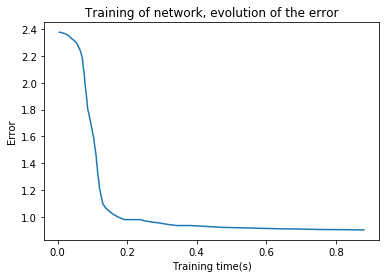

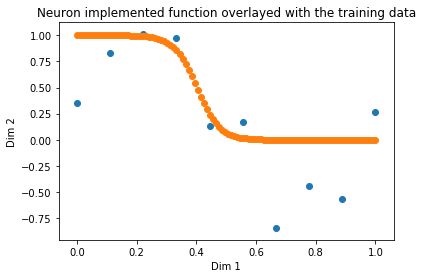

In [86]:
# Add ones to left hand side of training data array --> bias
trainones = np.ones((len(train),2))
trainones[:,1] = train[:,0]

# Error function, calculates total error using network inputs,targets and weights --> returns np.float64 
def errorfunc(w):
    error = 0
    for i in range(len(trainones)):
        output = neuron(w,trainones[i])
        error += .5*sse(output,traint[i])
    return error

# Gradient of error function w.r.t. each input weight --> returns a np.array of np.float64
def graderrorfunc(w):
    graderror = 0
    for i in range(len(trainones)):
        output = neuron(w,trainones[i])
        target = traint[i]
        graderror += ((output-target)*(output*(1-output)))*trainones[i]
    return graderror

# Test errorfunc and graderrorfunc
w = [0,0]
print("Error is:",errorfunc(w))
print("Gradient error is:",graderrorfunc(w))

# Train network using SGD
[wfinal, errs, ts] = gradDesc(w, errorfunc, graderrorfunc,1e-3,True,1000)

# Plot train error over time
plt.plot(ts,errs) # ts = training time
plt.xlabel('Training time(s)')  #X-axis label
plt.ylabel('Error') #Y-axis label 
plt.title("Training of network, evolution of the error") #Chart title. 

# Generate plot axis and test data
axis = np.linspace(0,1,100)
# test = np.linspace(0,1,100)
# test = [rd.uniform(0, 1) for _ in range(0, 100)]

# Calculate output of the network using final weights
output = []
for i in range (len(test)):
    output.append(neuron(wfinal,[1,axis[i]]))

# Plot neuron function and training data    
plt.figure()
plt.scatter(train,traint)
plt.plot(axis,output)
plt.xlabel('Dim 1')  #X-axis label
plt.ylabel('Dim 2') #Y-axis label 
plt.title("Neuron implemented function overlayed with the training data") #Chart title. 


## Defining and training a network

First, let us have a look at the implementation of the error and activation functions. As you have noticed above, there is a lot of duplicated code between the functions and their gradient and, therefore, a lot of wasted computation. We can reduce this problem by implementing functions that return both the computed function value and the value of the gradient for a given input. Here are a few examples of such implementations

In [6]:
# This code is given
# The following functions are activation functions. For efficiency, they combine the computation of 
# the activation function itself and its gradient wrt its input values, as both often rely on computing 
# the same intermediate quantities

def ssegf(y,t):
    '''Error and gradient function for sum-of-squares'''
    d = (y-t)
    return .5*d**2, d

def linvgf(a):
    '''Value and gradient function for linear activation'''
    return a,np.ones(a.shape)

**Question 6 [10 credits]**: Implement the logistic (sigmoidal) and the hyperbolic tangent "Value and Gradient" activation functions, ``logitvgf`` and ``tanhvgf``.

In [7]:
#ANSQ6
def logitvgf(a):
    if a<-40.:
        s = 0.
    if a>40.:  
        s = 1.
    else:
        s = 1./(1.+np.exp(-a))
    return s,s*(1.-s)

def tanhvgf(a):
    if a<-40.:
        s = -1
    if a>40.:
        s =1
    else:
        s= (np.exp(2*a)+1.)/(np.exp(2*a)-1.)
    return s,1-s**2
tahnvgf = np.vectorize(tanhvgf)
#/ANSQ6


We define a feed-forward neural network using the following information:
1. The number of layers in the network
1. The number of nodes in each layer
1. The activation function used in each layer (notice that all nodes in a layer use the same activation function)

The important thing to notice in such a network, is that the input of the nodes in layer $n$ are the outputs of the nodes in layer $n-1$, so that we have a chaining of functions and the chain rule of derivatives applies directly. We can, therefore, apply the chain rule mechanically and compute the gradient using a combination of the forward-propagated inputs and backward-propagated errors.

The code below implements a neural network with arbitrary numbers of hidden nodes, arbitrary numbers of hidden layers, and arbitrary activation functions. Do look at the code and make sure you understand how it works, and how to use it. 

In [8]:
class NN:
    '''Implementation of an artificial neural network'''
    def __init__(self, nIn, nodesPerLayer, actFn):
        '''Initialise the network with random weights and biases. 
        Parameters are:
        nIn: Number of input nodes (dimensionality of the data)
        nodePerLayer: Tuple of numbers of hidden nodes, one integer per layer, including the output layer
        actFn: Tuple of activation functions; one function per computational layer (hidden or output)'''
        
        assert(len(nodesPerLayer) == len(actFn))  # Check that the parameters are consistent
        
        self.numNodes = [nIn]                     # Create a list of numbers of nodes per layer
        if nodesPerLayer:
            self.numNodes.extend(nodesPerLayer)
        self.reinit()
        self.actfn = actFn
        
    def reinit(self,eta=1.0):
        '''Re-initialise weights with random values'''
        # Initialise weights and biases
        self.w = [ eta * np.random.randn(self.numNodes[i],self.numNodes[i-1]) for i in range(1,len(self.numNodes)) ]
        # print "Weights", self.w
        self.biases = [ eta * np.random.randn(self.numNodes[i]) for i in range(1,len(self.numNodes))]
        # print "Biases:", self.biases
        
    def forward(self,x):
        ''' Compute the activations of the nodes of each layer.
            For efficiency, use "VGF" functions and store the gradient of the activation function as well. In
            other words each entry of self.fw is a tuple containing (z_i, h'(a_i))
        '''
        self.fw = [ self.actfn[0](self.w[0].dot(x) + self.biases[0]) ]  # First layer takes data as input
        for h,w,b in zip(self.actfn[1:],self.w[1:],self.biases[1:]):    # following layers take the output of  
            self.fw.append(h(w.dot(self.fw[-1][0]) + b))                #    the previous layer
        return self.fw[-1][0]
    
    def back(self, errorgrad):
        '''Implement backpropagation of the errors'''
        self.delta = [ self.fw[-1][1] * errorgrad ]             # Start with the gradient of the error function
        
        for layer in range(len(self.w)-1,0,-1):
            hprime = self.fw[layer-1][1]                        # h'(a_j)
            delta = self.delta[0]                               # list gets extended at start, first elt: delta_k
            w = self.w[layer]                                   # w_kj

            self.delta.insert(0,hprime * (self.delta[0].dot(w))) # Use dot product to sum over all FOLLOWING weights        

    def gradients(self, x, t, eta=1e-3):
        '''Compute the gradients of the error of a single datapoint, with respect to
        all weights and all biases'''
        y = self.forward(x)                        # Forward propagation and computation of h'
        error = y-t
        self.back(error)                           # Backward propagation
                              
        gradw = []
        gradb = []
        gradw.append(np.outer(self.delta[0],x))    # derivative wrt w_ji = delta_j z_i, where z_i == x_i for input nodes
        gradb.append(self.delta[0])                #    and z_i == 1 for bias nodes
        
        for i in range(1,len(self.w)):
            gradw.append(np.outer(self.delta[i],self.fw[i-1][0])) # for folloing layers, use output of previous layer
            gradb.append(self.delta[i])
        return gradw,gradb,.5*error*error          # Return gradient wrt w and bias, and the error

    def batchGradients(self, data,targets):
        '''Compute the gradients of all weights and biases, for the complete dataset'''                      
        gradw,gradb,error = self.gradients(data[0,:],targets[0])
        for x,t in zip(data[1:,:],targets[1:]):
            tw,tb,e = self.gradients(x,t)
            error += e
            for i in range(len(gradw)):
                gradw[i] += tw[i]
                gradb[i] += tb[i]
        return gradw,gradb,error
    
    def batchStep(self,data,targets,eta=1e-3):
        '''Make one step of batch gradient descent'''
        gw,gb,e = self.batchGradients(data,targets)
        for i in range(len(gw)):
            self.w[i] -= eta*gw[i]
            self.biases[i] -= eta*gb[i]
        return e
       
    def train(self,data,targets,eta=1e-4, minit=100, maxit=10000):
        '''Train the network using batch GD'''
        es = np.zeros(maxit)
        for i in range(maxit):
            es[i] = self.batchStep(data,targets,eta)
            if i>minit and es[i-1]< es[i]+1e-5:
                return es[:i+1]
        return es
    
    def stochStep(self,data,targets,eta=1e-3):
        '''Make one step of batch gradient descent'''
        l = np.random.randint(data.shape[0])
        gw,gb,e = self.gradients(data[l,:],targets[l])
        for i in range(len(gw)):
            self.w[i] -= eta*gw[i]
            self.biases[i] -= eta*gb[i]
        return e

    def stochtrain(self,data,targets,eta=1e-4, minit=100, maxit=10000):
        '''Train the network using batch GD'''
        es = np.zeros(maxit)
        for i in range(maxit):
            es[i] = self.batchStep(data,targets,eta)
            if i>minit and es[i-1]< es[i]+1e-5:
                return es[:i+1]
        return es    

Using the above code, let's create a neural network with one layer with hyperbolic tangent activation function, and one output node with linear output activation function, and train it on the provided data. We plot the evolution of the training error, as well as the function that the neural network implements (in two separate plots). 

In [9]:

net = NN(1,(5,1),(tanhvgf,linvgf,))
net.reinit(eta=1.)
errors = net.train(train,traint,1e-3,minit=100,maxit=10000)
plt.plot(errors)
plt.figure()
plt.scatter(train,traint)
x = np.arange(0,1,.01)
y = np.array([float(net.forward([d])) for d in x])
plt.plot(x,y)
# print (net.w)
# print (net.biases)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

**Question 6 [30 credits]** Use the provided test data to compare this to other configurations of your choice (more hidden layers, different activation functions, ...). Find a network that performs well on the given data. Perform multiple training runs with random initialisations, plot the final validation error for each run in function of the number of nodes, and keep the best. Plot the train and test data, as well as the function implemented by your final network

In [ ]:
test = np.array([data['test'][:,0]]).T
testt = data['test'][:,1]

In [ ]:
#ANSQ6
%qtconsole

#/ANSQ6